# Zillow House Tax Values

## Imports

In [1]:
# import data tools
import numpy as np
import pandas as pd

import wrangle as w
import explore as e
import modeling as m

import matplotlib.pyplot as plt
import seaborn as sns

## Acquire

* Data was acquired from the Codeup database
* The data was initially 52320 rows and 11 columns
* Each row represents one house that had a transaction in 2017
* Each column represents one aspect of the house

In [2]:
# Importing data and first cleaning
train, validate, test = w.wrangle_zillow()

opening data from local file


## Prepare

* We removed outlier rows from the area, bathrooms or bedrooms columns.
* We filled in null values in the garage_sqft and cars_garage columns with 0
* We imputed the most common region based on the fips value
* We converted the data types to integer for all the columns except number of bathrooms
* After cleaning there were 45,517 rows of data

The dataset contains the variable 'fips', which translates to:
- 6037 - Los Angeles County, California
- 6059 - Orange County, California
- 6111 - Ventura County, California

In [3]:
# Spliting data and imputing missing values
train_scaled, validate_scaled, test_scaled = w.impute_and_scale(train, validate, test)

## Explore

* Does tax value correlate to the square footage of the house?
* Does tax value correlate to the property's lot size?
* Does tax value correlate to the number of cars that fit in the garage?
* Does the number of cars that fit in the garage correlate to the size of the garage?

## Question - Does the square footage of the house have a linear correlation witih tax value?

## Hypothesis
Is there a linear corellation between the square footage (area) of the house and the tax value?
- H$_0$: There is no correlation between area and tax value
- H$_a$: There is a linear correlation between area and tax value
- alpha: 0.05
- This will be a pearsonsr test

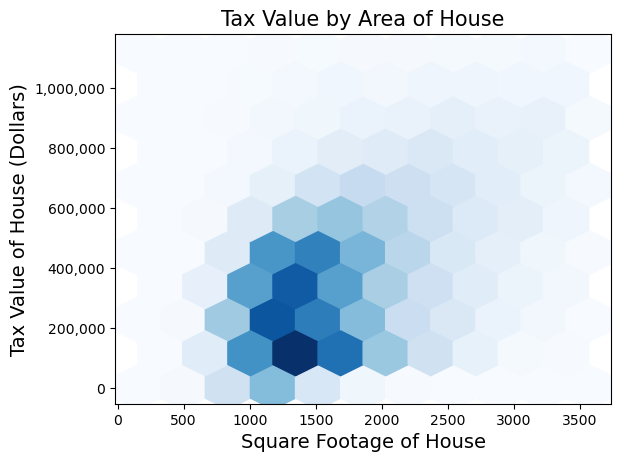

In [4]:
e.get_area_value(train)

In [5]:
e.get_pearson_area(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.45028158739912466


#### There is enough evidence to show that there is a linear relationship between the square footage (area) of the house and the tax value (r coeficient of 0.45).

## Question - Does property lot size have a correlation with the tax value of the house?

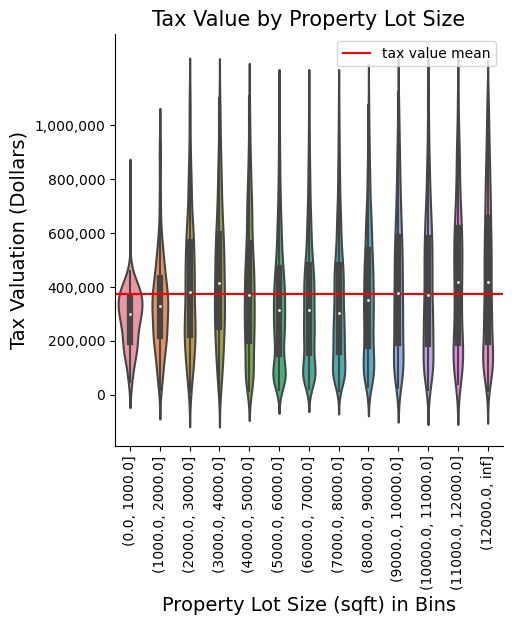

In [6]:
e.get_lot_bin_vis(train)

#### It seems that the tax_value is pretty evenly disbursed across every lot_size bin, so probably not a good estimator or tax_value (r coeficient of -0.0061)

## Question - Does the number of cars that fit in the garage have a correlation to the tax value of the house?

# Hypothesis
cars_garage has a linear correlation to tax_value
- H$_0$: There is no linear correlation between cars_garage and tax_value
- H$_a$: There is a linear correlation between cars_garage and tax_value
- Confidence interval / alpha: 95% / 0.05
- This will be a pearsonsr correlation test

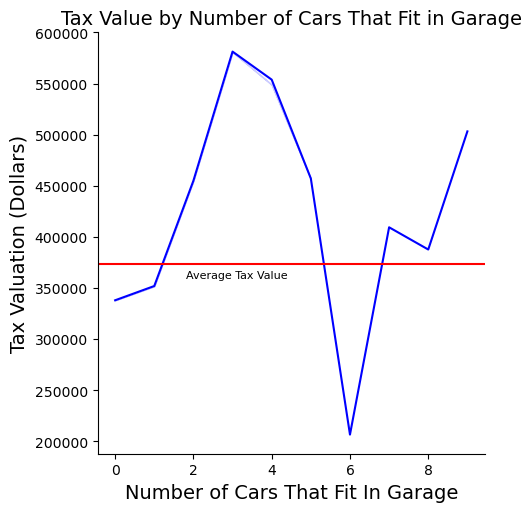

In [7]:
e.get_cars_value(train)

In [8]:
e.get_pearson_garage(train)

there is sufficient evidence to reject our null hypothesis
the p-value is 0.0
the r coeficient is 0.24177353734407273


#### There is enough evidence to show that there is a linear correlation between the number of cars that fit in the property's garage and the tax value (r coeficient of 0.24)

## Question - Does the garage square footage have a correlation to the amount of cars that can fit within it?

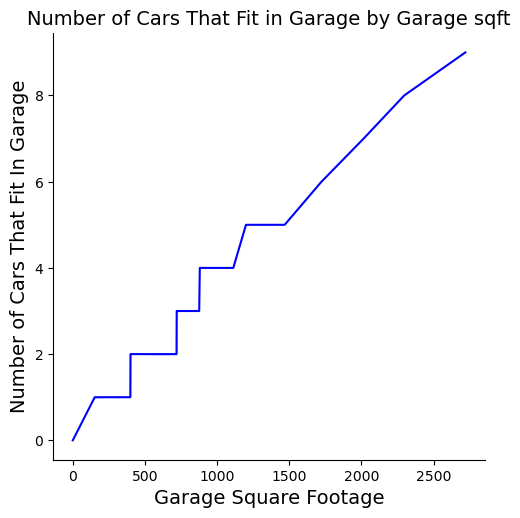

In [9]:
e.get_cars_by_sqft(train)

#### Garage square footage appears to have a very strong correlation to the number of cars that fit within the garage. (r coeficient of 0.98) So we will probably only want to use one of these variables in our modeling.

## Exploration Summary
* We found that:
* Square footage of the house has the strongest correlation to the property's tax value
* Square footage of the property's lot has a very weak correlation to the tax value
* Square footage of the garage has a moderate correlation to the property tax value
* The amount of cars that fit in the garage have a very strong correlation to the square footage of the garage

### Features selected for modeling:
We will be using these features for modeling:
- 'pools', 'year_built', 'area', 'garage_sqft', 'region'

## Modeling

### Introduction
* Since we are looking at a linear regression problem we will be looking at the RMSE and R$^2$ metrics.
* RMSE evaluates the amount of error from the actual values present in the model
* R$^2$ is a measure of the amount of variance from the mean value explained by our model

In [10]:
# setup datasets for modeling
drops = ['tax_value','lot_size_binned']
X_train_scaled = train_scaled.drop(columns=drops)
y_train = pd.DataFrame(train_scaled.tax_value)
X_validate_scaled = validate_scaled.drop(columns=drops)
y_validate = pd.DataFrame(validate_scaled.tax_value)
X_test_scaled = test_scaled.drop(columns=drops)
y_test = pd.DataFrame(test_scaled.tax_value)
# list the chosen features to use
f_features = ['pools', 'year_built', 'area', 'garage_sqft', 'region']

In [11]:
m.get_baseline_model(y_train)

Baseline Model (mean)
RMSE for baseline model: 243722.13
R^2 for baseline model: 0.0


## Lasso + Lars Model

In [12]:
lars = m.get_lars_model(X_train_scaled, y_train, 
                   X_validate_scaled, y_validate, f_features)

Lasso + Lars Model
RMSE on training data: 215268.7
RMSE on validation data: 219013.26
Difference in RMSE: 3744.5551
R^2 value: 0.2082


## Generalized Linear Model

In [13]:
glm = m.get_tweedie_model(X_train_scaled, y_train, 
                      X_validate_scaled, y_validate, f_features)

Tweedie Model
RMSE on training data: 243722.13
RMSE on validation data: 246130.97
Difference in RMSE: 2408.842
R^2 value: 1.11e-16


## Polynomial Regression Model

In [14]:
lm2, X_test_degree2 = m.get_polynomial_model(X_train_scaled, y_train, 
                         X_validate_scaled, y_validate,
                         X_test_scaled, f_features)

Polynomial Model
RMSE on training data: 210452.03
RMSE on validation data: 213462.82
Difference in RMSE: 3010.7873
R^2 value: 0.2478


### Test Model
* We will be using the Polynomial Regression Model for the test data
* The Polynomial Regression Model had the highest R$^2$ value while also having a low RMSE and low variation between train and validate datasets

In [15]:
y_test = m.get_polynomial_test(lm2, X_test_degree2, y_test)

Polynomial Model on Test Data
RMSE on test data: 213160.52
R^2 value: 0.244


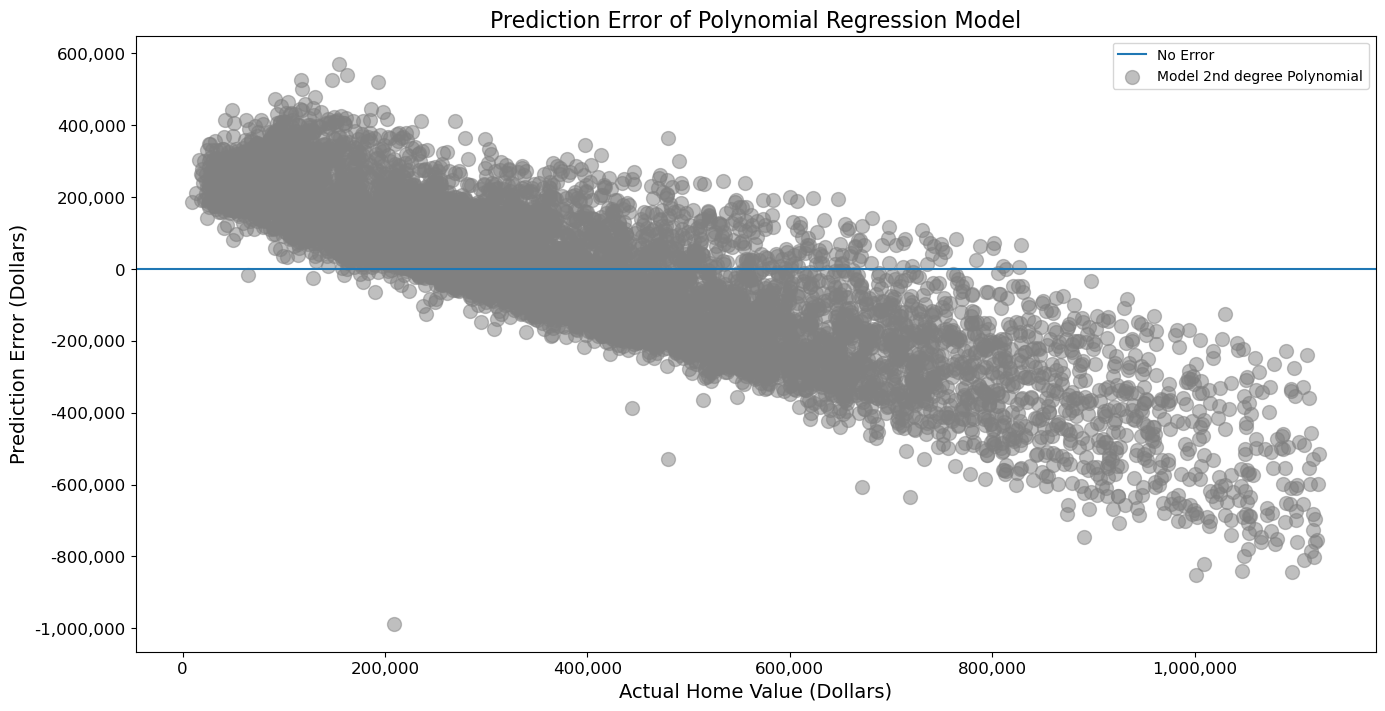

In [16]:
m.get_pred_error_plot(y_test)

### Modeling Wrap 
* Our Polynomial Regression model was able to reduce the error from the baseline prediction model by \\$30,561 per property, with a total reduction in error for all houses that had a transaction in 2017 by \\$1,391,072,837 (1.39 billion dollars).

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.